# **Statistical Evaluation**

This Notebook performs the statistical evaluation of our synthetic product reviews:

* Statistical tendencies (Zipf's law)
* Linguistic features (review length, type-token ratio, verb and noun usage using POS tagging, readability scores)
* MAUVE
* Human evaluation (inter-rater reliability and PERMANOVA)

## Preparation

In [1]:
# Install packages if you have not already
!pip install stanza
!pip install textstat
!pip install mauve-text
!pip install krippendorff
!pip install scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 58.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 11.1 MB/s eta 0:00:0000:010:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=2504426 sha256=8c1d025d5051d0c6d5895426304ff680f795b4c29fb1d8a4e3a0c8cb162619d8
  Stored in directory: /root/.cache/pip/wheels/f3/9

In [6]:
# Import packages
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import scipy.stats as stats
import nltk
from nltk.corpus import stopwords
from scipy.special import zetac
from scipy.stats import chi2
from scipy.optimize import minimize
import stanza
import textstat
import mauve
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
from transformers import set_seed

# Download additional files for NLTK and stanza
nltk.download('punkt')
nltk.download('stopwords')

stanza.download('en')

# Set seed for reproducible and consistent results
set_seed(42)

## Load and prepare the data

### Real product reviews

In [ ]:
# Load real product reviews
with ZipFile('checkpoint3.zip', 'r') as zip1:
    with zip1.open('checkpoint3.csv') as file:
        real_reviews = pd.read_csv(file)

# Sample 10,000 reviews
real_reviews = real_reviews.sample(n=10000, random_state=42)

# Tokenize, clean, and turn text into array
revs_real = real_reviews['Text'].copy()

words_list_real = []
words_lists_real = []

for rev in revs_real:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_real.extend(tokens)
    words_lists_real.append(tokens)

# Concatenate reviews
full_text_real = " ".join(real_reviews.dropna().tolist())

### GPT-2 generated product reviews

In [3]:
# Load GPT-2 generated product reviews
gpt2_reviews = pd.read_csv('/kaggle/input/gpt2-reviews/GPT2_sample.csv')

# Tokenize, clean, and turn text into array
revs_gpt2 = gpt2_reviews['Generated Review'].copy()

words_list_gpt2 = []
words_lists_gpt2 = []

for rev in revs_gpt2:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_gpt2.extend(tokens)
    words_lists_gpt2.append(tokens)

# Concatenate reviews
full_text_gpt2 = " ".join(gpt2_reviews.dropna().tolist())

### LLaMA 3 generated product reviews

In [ ]:
# Load LLaMA 3 generated product reviews
llama3_reviews = pd.read_csv('/kaggle/input/.../.csv')

# Tokenize, clean, and turn text into array
revs_llama3 = llama3_reviews['Generated Review'].copy()

words_list_llama3 = []
words_lists_llama3 = []

for rev in revs_llama3:
    # Tokenize each review
    tokens = nltk.word_tokenize(rev)
    # Turn to lower and keep only alphanumeric tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Add to results list
    words_list_llama3.extend(tokens)
    words_lists_llama3.append(tokens)

# Concatenate reviews
full_text_llama3 = " ".join(llama3_reviews.dropna().tolist())

## Statistical tendencies

### Log-log plot of of word rank vs. word frequency

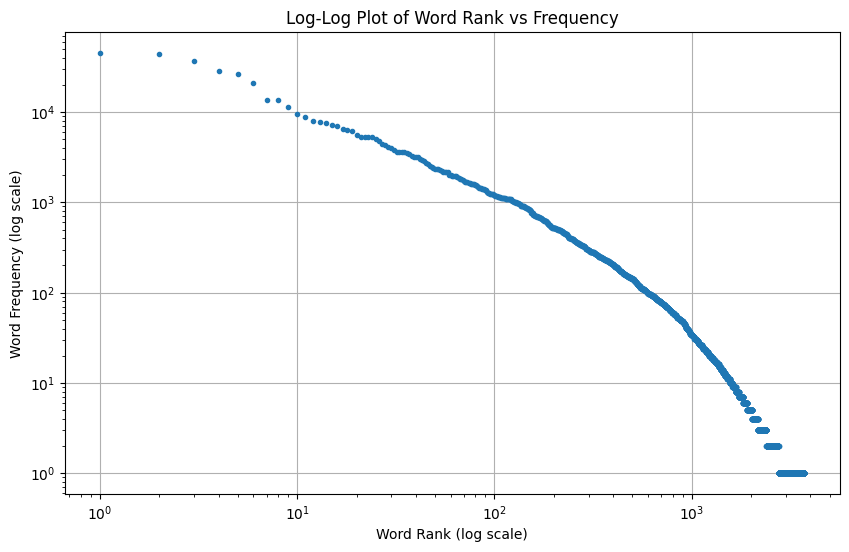

In [4]:
def create_loglogplot(words_list):
    # Count word frequencies
    word_counts = Counter(words_list)

    # Rank the words
    frequencies = np.array(sorted(word_counts.values(), reverse=True))

    # Generate ranks
    ranks = np.arange(1, len(frequencies) + 1)

    # Create the log-log plot
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker=".", linestyle='none')
    plt.title("Log-Log Plot of Word Rank vs Frequency")
    plt.xlabel("Word Rank (log scale)")
    plt.ylabel("Word Frequency (log scale)")
    plt.grid(True)
    plt.show()

    return frequencies, ranks

In [ ]:
# Log-log plot for the real product reviews
frequencies_real, ranks_real = create_loglogplot(words_list_real)

In [ ]:
# Log-log plot for the GPT-2 generated product reviews
frequencies_gpt2, ranks_gpt2 = create_loglogplot(words_list_gpt2)

In [ ]:
# Log-log plot for the LLaMA 3 generated product reviews
frequencies_llama3, ranks_llama3 = create_loglogplot(words_list_llama3)

### Likelihood ratio test

In [8]:
def LRT(frequencies, ranks):
    
    # Define a function for the Zipf probability distribution
    def zipf_pmf(rank, s, N):
        # Proper normalization for Zipf distribution using generalized harmonic number
        harmonic_number = np.sum(1 / np.arange(1, N+1) ** s)
        return (1 / rank ** s) / harmonic_number

    # Define a function to compute the log-likelihood for Zipf's law
    def log_likelihood_zipf(frequencies, ranks, s):
        N = len(ranks)
        pmf_values = np.array([zipf_pmf(rank, s, N) for rank in ranks])
        
        # Avoid log(0) by ensuring all probabilities are non-zero
        pmf_values[pmf_values == 0] = np.finfo(float).eps # Very small value instead of 0
        
        log_likelihood = np.sum(frequencies * np.log(pmf_values))
        return log_likelihood

    # Define a function for the alternative model's probability distribution (e.g., uniform)
    def uniform_pmf(rank, N):
        return 1 / N

    # Define a function to compute the log-likelihood for the alternative model
    def log_likelihood_uniform(frequencies, ranks):
        N = len(ranks)
        pmf_values = np.array([uniform_pmf(rank, N) for rank in ranks])
        
        # Avoid log(0)
        pmf_values[pmf_values == 0] = np.finfo(float).eps
        
        log_likelihood = np.sum(frequencies * np.log(pmf_values))
        return log_likelihood

    # Estimate the parameter s for Zipf's law using maximum likelihood estimation (MLE)

    # Negative log-likelihood function for Zipf's law
    def neg_log_likelihood_zipf(s, frequencies, ranks):
        return -log_likelihood_zipf(frequencies, ranks, s)

    # Initial guess for s
    initial_s = 1.0

    # Perform MLE to estimate the best s
    result = minimize(neg_log_likelihood_zipf, initial_s, args=(frequencies, ranks), bounds=[(0.01, 5)])
    best_s = result.x[0]

    # Calculate the log-likelihoods for both models
    log_likelihood_zipf_model = log_likelihood_zipf(frequencies, ranks, best_s)
    log_likelihood_uniform_model = log_likelihood_uniform(frequencies, ranks)

    # Compute the likelihood ratio test statistic
    likelihood_ratio_statistic = -2 * (log_likelihood_uniform_model - log_likelihood_zipf_model)

    # Perform chi-square test to get the p-value (df=1, since we only estimate s for Zipf's law)
    p_value = chi2.sf(likelihood_ratio_statistic, df=1)

    # Print results
    if frequencies == frequencies_gpt2:
        print('Result for GPT-2 \n')
    else:
        print('Result for LLaMA 3 \n')
    print(f"Best Zipf exponent s: {best_s}")
    print(f"Likelihood Ratio Statistic: {likelihood_ratio_statistic}")
    print(f"P-value: {p_value:.10f}")

Best Zipf exponent s: 0.01
Likelihood Ratio Statistic: 56547.55180223659
P-value: 0.0000000000


In [ ]:
# LRT for GPT-2 generated product reviews
LRT(frequencies_gpt2, ranks_gpt2)

In [ ]:
# LRT for LLaMA 3 generated product reviews
LRT(frequencies_llama3, ranks_llama3)

## Linguistic features

In [15]:
# Initialize the Stanza pipeline for English language
nlp = stanza.Pipeline('en', processors='tokenize,pos')

# Define a function for analyzing the linguistic features of the data
def compute_linguistic_features(words_list, words_lists, full_text):

    # Function to calculate average length and standard deviation of review lengths
    def calculate_length_stats(words_lists):
        lengths = [len(rev) for rev in words_lists]
        avg_length = np.average(lengths)
        std_length = np.std(lengths)
        return avg_length, std_length

    # Function to calculate Type-Token Ratio (TTR)
    def calculate_ttr(words_list):
        types = set(words_list)  # Unique words
        ttr = len(types) / len(words_list) if len(words_list) > 0 else 0
        return ttr

    # Function to calculate percentage of nouns and verbs in a corpus
    def calculate_pos_percentage(full_text):
        doc = nlp(full_text)
        total_words = 0
        noun_count = 0
        verb_count = 0

        for sentence in doc.sentences:
            for word in sentence.words:
                if word.upos == 'PUNCT':
                    continue
                total_words += 1
                if word.upos == 'NOUN':
                    noun_count += 1
                elif word.upos == 'VERB':
                    verb_count += 1

        noun_percentage = (noun_count / total_words) * 100 if total_words > 0 else 0
        verb_percentage = (verb_count / total_words) * 100 if total_words > 0 else 0
        return noun_percentage, verb_percentage

    # Function to calculate readability scores
    def calculate_readability(full_text):
        flesch_score = textstat.flesch_reading_ease(full_text)
        dale_chall_score = textstat.dale_chall_readability_score(full_text)
        return flesch_score, dale_chall_score

    # Calculate all the metrics
    avg_length, std_length = calculate_length_stats(words_lists)
    ttr = calculate_ttr(words_list)
    noun_percentage, verb_percentage = calculate_pos_percentage(full_text)
    flesch_score, dale_chall_score = calculate_readability(full_text)

    # Print all results
    print(f"Average length of reviews: {avg_length:.4f}")
    print(f"Standard deviation of review lengths: {std_length:.4f}")
    print(f"TTR: {ttr:.4f}")
    print(f"Percentage of nouns: {noun_percentage:.4f}%")
    print(f"Percentage of verbs: {verb_percentage:.4f}%")
    print(f"Flesch Reading Ease Score: {flesch_score:.4f}")
    print(f"Dale-Chall Readability Score: {dale_chall_score:.4f}")

Average length of reviews: 73.2916
Standard deviation of the length of reviews: 29.869984423162997
TTR of GPT-2: 0.005086531062222683
Flesch Reading Ease Score: 93.03
Dale-Chall Readability Score: 0.66


In [ ]:
# Linguistic features of real product reviews
compute_linguistic_features(words_list_real, words_lists_real, full_text_real)

In [ ]:
# Linguistic features of GPT-2 generated product reviews
compute_linguistic_features(words_list_gpt2, words_lists_gpt2, full_text_gpt2)

In [ ]:
# Linguistic features of LLaMA 3 generated product reviews
compute_linguistic_features(words_list_llama3, words_lists_llama3, full_text_llama3)

## MAUVE

In [ ]:
# Compute MAUVE score for GPT-2 generated reviews vs real reviews
mauve_gpt2 = mauve.compute_mauve(p_text=revs_real.tolist(), q_text=revs_gpt2.tolist(), device_id=0)

print(f"MAUVE score: {mauve_gpt2.mauve}")

In [ ]:
# Compute MAUVE score for LLaMA3 generated reviews vs real reviews
mauve_llama3 = mauve.compute_mauve(p_text=revs_real.tolist(), q_text=revs_llama3.tolist(), device_id=0)

print(f"MAUVE score: {mauve_llama3.mauve}")

## Human evaluation

### Inter-rater reliability

In [ ]:
# Load the data with the ratings


In [ ]:
# Calculate Krippendorff's Alpha
alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement='ordinal')
print(f"Krippendorff's Alpha: {alpha}")

# Calculate Fleiss' Kappa
kappa = fleiss_kappa(ratings)
print(f"Fleiss' Kappa: {kappa}")

### PERMANOVA

In [ ]:
# Distance matrix (Euclidean distances between rows based on ratings across 4 criteria)
dm = DistanceMatrix.from_iterable(data.iloc[:, 1:], metric='euclidean')

# Run PERMANOVA
grouping = data['Model']
permanova_results = permanova(dm, grouping, permutations=999)
print(permanova_results)